# TP Optimisation II:  A simple neural network 

### Nom(s): 
### Prénom(s): 
### Groupe:

## Useful packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [2]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('there are ',Xtrain.shape[0],'images in the train set')
print('there are ',Xtest.shape[0],'images in the test set')

there are  60000 images in the train set
there are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [3]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    temp  = np.exp(x + alpha)
    value = temp / np.sum(temp)
    
    return value

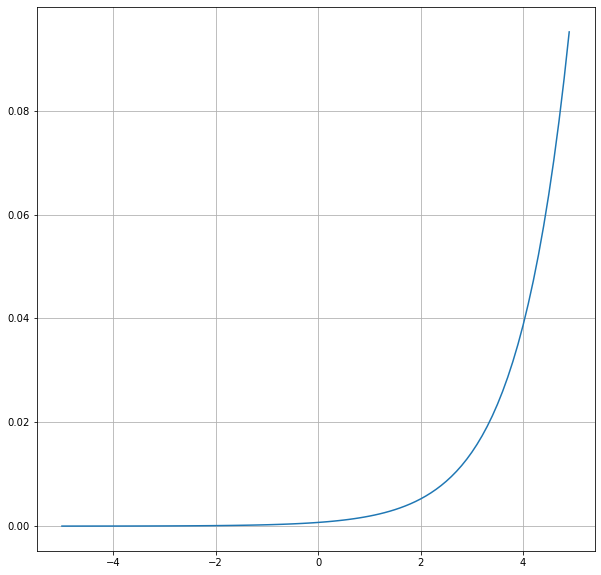

In [4]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = 0. #np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [5]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    temp = W.dot(x)
    pred = softmax(temp, -np.max(temp))
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [6]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred, target, x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    ce = -target.T.dot(np.log(pred))
    u    = np.ones((np.shape(pred)[0], 1))
    g    = (-u.T.dot(target) * (pred.dot(x.T)) +  target @ x.T)
    
    grad = -g.reshape(np.shape(x)[0] * np.shape(target)[0], 1)
    return ce,grad

#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    pred    = NN(x,W)
    ce,grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [7]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

[[0.73745968]]
[[0.73745962]]


## Generating batches 

In [8]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [9]:
def grad_f_batch(W, batch):
    grad_batch = 0
    for ind in batch:
        x = Xtrain[ind]
        target = targets_train[ind]
        _,grad,_ = f(W,x,target)
        grad_batch += grad
        
    grad_batch = grad_batch / batch.shape[0]
    
    return grad_batch

In [10]:
def benchmark(W, X, targets):
    m = X.shape[0]
    acc = 0
    loss = 0
    for i in range(m):
        x = X[i]
        target = targets[i]
        ce,_,pred = f(W, x, target)
        loss += ce
        if np.argmax(target) == np.argmax(pred):
            acc += 1
    acc = acc / m
    loss = loss / m
    
    return acc, loss[0][0]    

In [12]:
history    = {}
eta        = 1e-3 # learning rate
momentum   = 0.3   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis
#BatchSizes = [256]

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs] = {'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])

    change = np.zeros(np.shape(w))
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        Batches = create_batches(Xtrain, bs)
        
        for batch in Batches:
            # Loop on the batches
            grad_batch = grad_f_batch(w, batch)
            new_change = eta * grad_batch.reshape(np.shape(w)) + momentum * change
            w = w - new_change
            change = new_change
                                
        # Test accuracy at the end of each epoch
        train_acc, train_loss = benchmark(w, Xtrain, targets_train)  
        history[bs]['train acc'].append(train_acc)
        history[bs]['train loss'].append(train_loss)
    
        test_acc,test_loss = benchmark(w, Xtest, targets_test)
        history[bs]['test acc'].append(test_acc)
        history[bs]['test loss'].append(test_loss)  
                    
            
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.0772 test loss 4.423902394230477
Epoch number : 2 test accuracy: 0.0782 test loss 4.385981505654757
Epoch number : 3 test accuracy: 0.0787 test loss 4.349606591104188
Epoch number : 4 test accuracy: 0.0804 test loss 4.3146645550448595
Epoch number : 5 test accuracy: 0.0829 test loss 4.281102428731463
Epoch number : 6 test accuracy: 0.0841 test loss 4.2487654497657035
Epoch number : 7 test accuracy: 0.0847 test loss 4.217627328831438
Epoch number : 8 test accuracy: 0.0873 test loss 4.187639171978556
Epoch number : 9 test accuracy: 0.0877 test loss 4.1586477184887665
Epoch number : 10 test accuracy: 0.0891 test loss 4.130651555151717


batch size= 1024
Epoch number : 1 test accuracy: 0.1536 test loss 3.7345573646493153
Epoch number : 2 test accuracy: 0.16 test loss 3.5579880953972722
Epoch number : 3 test accuracy: 0.1683 test loss 3.4124302681223324
Epoch number : 4 test accuracy: 0.1761 test loss 3.2870497994340564
Epoch number : 5 te

## Plots of the evolution of the loss function

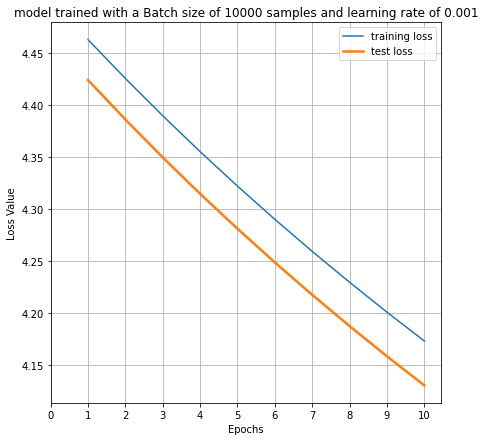

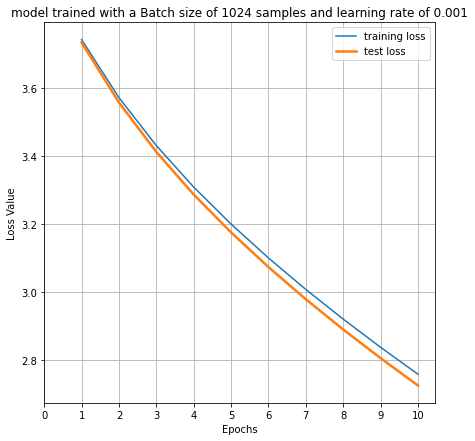

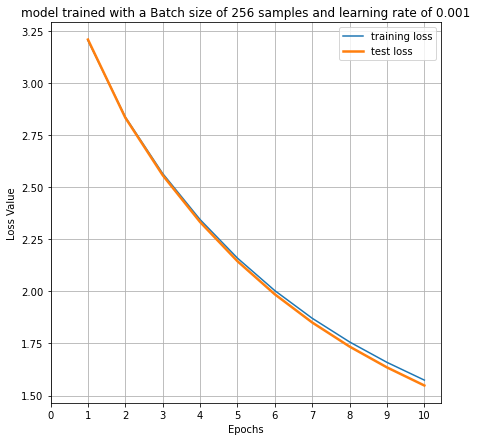

In [24]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
        
    plt.figure(figsize=(7,7))
    plt.plot(E[1:],history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000


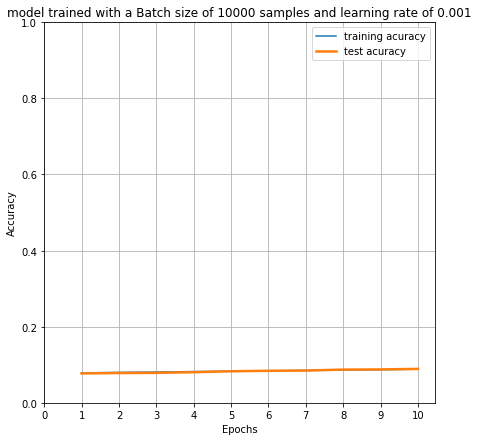

1024


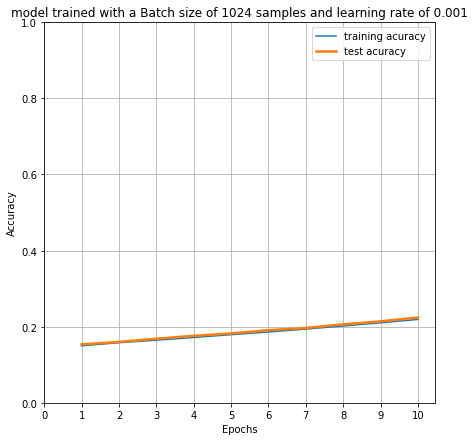

256


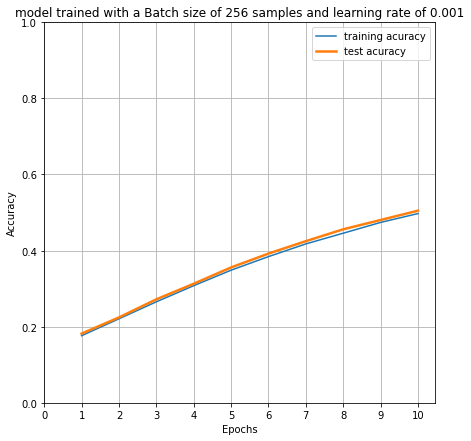

In [25]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(E[1:],history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments: